# Задача прогнозирования оттока клиентов банка

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Напомним значения столбцов:

* RowNumber — номер строки таблицы;
* CustomerId — идентификатор клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* Geography — страна проживания клиента (банк межнациональный);
* Gender — пол клиента;
* Age — возраст клиента;
* Tenure — сколько лет клиент пользуется банком;
* Balance — сколько у клиента денег на счетах в банке;
* NumOfProduct — число услуг банка, которые приобрёл клиент;
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* IsActiveMember — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);
* EstimatedSalary — предполагаемая заработная плата клиента;
* Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

### 1. Обработка данных

В данных мы имеем признак "Geography", который содержит три значения: Германия, Франция, Испания.   
  
Отток клиентов в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Выделим только данные, относящиеся к Германии:

In [3]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

In [4]:
# избавляемся от неинформативных признаков
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [5]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### 2. Создание и преобразование признаков

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

* BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
* TenureByAge — отношение времени пользования банком к возрасту клиента;
* CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

In [6]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

In [7]:
# перекодируем признак пола в бинарный признак
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [8]:
X = churn_data.drop("Exited", axis=1) #наблюдения
y = churn_data["Exited"] #ответы

In [9]:
#проводим нормализация матрицы наблюдений Х
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [10]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Классы не сбалансированы. Ушедших пользователей — 32 %, в то время как лояльных — 68 %. 

In [11]:
#выполним разбиение, установив значением параметра random_state число 0:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

# Train shape: (1881, 12)
# Test shape: (628, 12)

Train shape: (1881, 12)
Test shape: (628, 12)


In [12]:
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


### 3. Обучаем модель

По условию задачи наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра, а для клиентов, у которых вероятность оттока наиболее высока, — специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому ложные срабатывания желательно минимизировать. Однако в то же время необходимо сохранить как можно больше клиентов.  

В данной задаче нам нужен баланс между precision и recall, поэтому мы будем использовать F1-меру.

In [13]:
#Создаём объект класса LogisticRegression
log_reg_churn = linear_model.LogisticRegression(random_state=42)
#Обучаем модель, минимизируя logloss
log_reg_churn.fit(X_train, y_train)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_churn.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_churn.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [-0.31350185]
w1, w2: [[ 0.66460378 -0.44529541  2.32397954  0.5734533   0.36604364 -0.80010982
  -0.08103818 -0.96394777 -0.21489639  0.57754047 -1.2334926  -3.01169638]]


In [14]:
y_pred_train = log_reg_churn.predict(X_train)
y_pred_test = log_reg_churn.predict(X_test)

In [15]:
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.49
F1 score: 0.47


### 3.1. Регуляризация

In [16]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
 
print(X_train_poly.shape)
print(X_test_poly.shape)

(1881, 454)
(628, 454)


### 3.2. Обучение модели на полиноминальных признаках

In [17]:
#Создаём объект класса LogisticRegression
log_reg_churn_poly = linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')
#Обучаем модель, минимизируя logloss
log_reg_churn_poly.fit(X_train_poly, y_train)
#Выводим результирующие коэффициенты
#print('w0: {}'.format(log_reg_churn_poly.intercept_)) #свободный член w0
#print('w1, w2: {}'.format(log_reg_churn_poly.coef_)) #остальные параметры модели w1, w2, ..., wm

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [18]:
y_pred_train_poly = log_reg_churn_poly.predict(X_train_poly)
y_pred_test_poly = log_reg_churn_poly.predict(X_test_poly)

In [19]:
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train_poly)))

#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test_poly)))

F1 score: 0.66
F1 score: 0.64


### 3.3. Определение порога вероятности

In [20]:
#Считаем вероятности оттока для каждого из клиентов
y_test_proba_pred = pd.Series(log_reg_churn_poly.predict_proba(X_test_poly)[:, 1])


#y_proba_pred = log_reg_churn_poly.predict_proba(X_train_poly)[:, 1]
#Для удобства завернём numpy-массив в Pandas Series
#y_proba_pred = pd.Series(y_proba_pred)
#Создадим список, в котором будем хранить значение метрики 
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги

for threshold in thresholds:
    #Клиентов, для которых вероятность оттока > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    f1_scores.append(metrics.f1_score(y_test, y_pred))

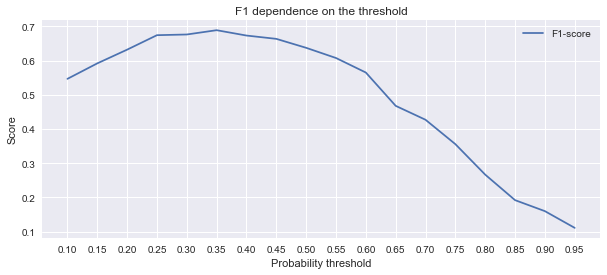

In [21]:
#Визуализируем метрики threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend()

In [22]:
threshold_opt = 0.35
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_opt)))

Test F1: 0.69


In [23]:
from sklearn import tree


dt = tree.DecisionTreeClassifier(
    max_depth=8, 
    criterion='entropy', 
    random_state=42,
    min_samples_leaf=10
)
 
dt.fit(X_train, y_train)
 
y_train_pred = dt.predict(X_train)
print('Train F1: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
 
y_test_pred = dt.predict(X_test)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train F1: 0.72
Test F1: 0.64


In [24]:
from sklearn import ensemble

#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500, 
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.74
Test: 0.66


/home/belov_engineer/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/belov_engineer/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


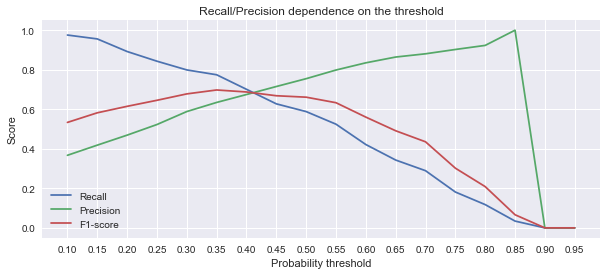

In [25]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend()

In [26]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Людей, у которых вероятность зарабатывать >50K больше 0.5 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       424
           1       0.63      0.77      0.70       204

    accuracy                           0.78       628
   macro avg       0.76      0.78      0.76       628
weighted avg       0.80      0.78      0.79       628

